### DenseNet

In [1]:
import os
import glob
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
tf.__version__

'2.10.1'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Examining the data

In [5]:
dataset_paths = ['./input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/',
                 './input/deepfake-and-real-images/Dataset/',
                 './input/real-vs-ai-generated-faces-dataset/dataset/dataset/']

In [6]:
status_map = {'0' : 'real',
              '1' : 'fake',
              'real' : 'real',
              'fake' : 'fake'}

where_map = {'test' : 'test',
             'train' : 'train',
             'valid' : 'valid',
             'validation' : 'valid',
             'validate' : 'valid'}

In [8]:
pd.options.display.max_colwidth = 100

dataset = {"image_path":[],"img_status":[],"where":[]}
for path in dataset_paths:
    for where in os.listdir(path):
        for status in os.listdir(path+"/"+where):
            for image in glob.glob(path+where+"/"+status+"/"+"*.jpg"):
                dataset["image_path"].append(image)
                dataset["img_status"].append(status_map.get(status.lower()))
                dataset["where"].append(where_map.get(where.lower()))

dataset = pd.DataFrame(dataset)
dataset

,image_path,img_status,where
0,./input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake\00276TOPP4.jpg,fake,test
1,./input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake\008BYSE725.jpg,fake,test
2,./input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake\009ZTJ3621.jpg,fake,test
3,./input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake\00F8LKY6JC.jpg,fake,test
4,./input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake\00JEP4Z36Z.jpg,fake,test
...,...,...,...
451284,./input/real-vs-ai-generated-faces-dataset/dataset/dataset/validate/1\SFHQ_pt4_00004978.jpg,fake,valid
451285,./input/real-vs-ai-generated-faces-dataset/dataset/dataset/validate/1\SFHQ_pt4_00004979.jpg,fake,valid
451286,./input/real-vs-ai-generated-faces-dataset/dataset/dataset/validate/1\SFHQ_pt4_00004980.jpg,fake,valid
451287,./input/real-vs-ai-generated-faces-dataset/dataset/dataset/validate/1\SFHQ_pt4_00004988.jpg,fake,valid


In [9]:
print(dataset.value_counts("img_status"),'\n')
print(dataset.value_counts("where"))

img_status
real    235201
fake    216088
Name: count, dtype: int64 

where
train    312576
valid     83618
test      55095
Name: count, dtype: int64


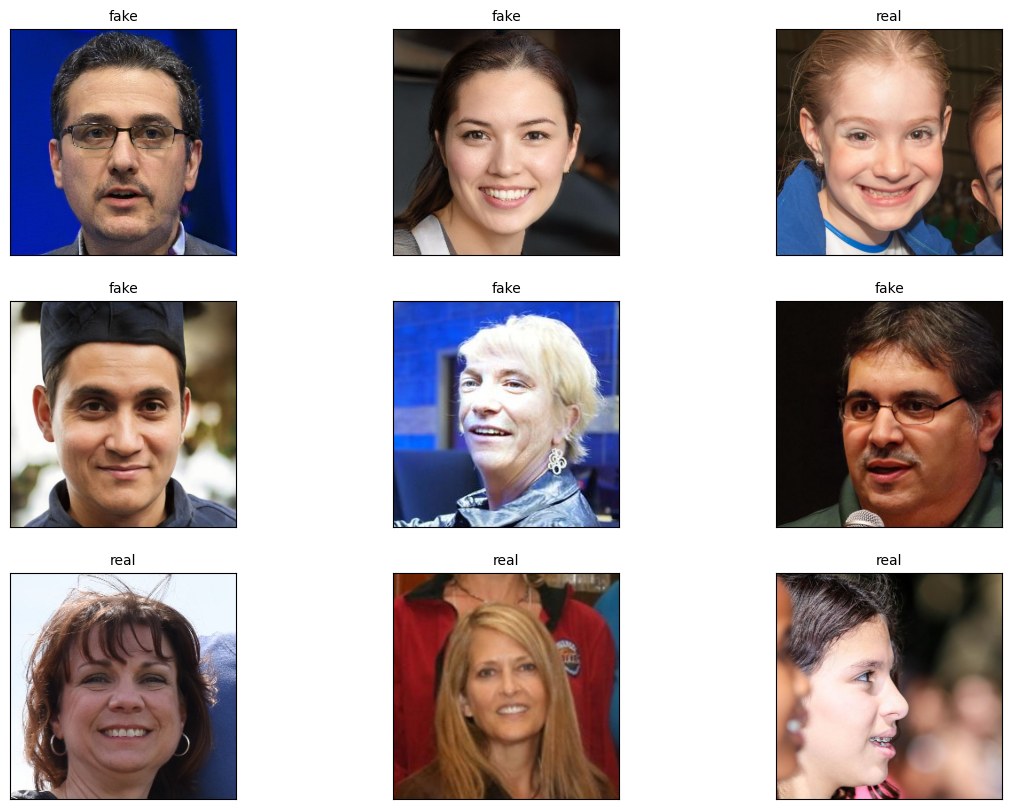

In [10]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "img_status"], size = 10) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

### Processing the data

In [11]:
test_df = dataset[dataset['where'] == 'test'].drop('where', axis=1)
valid_df = dataset[dataset['where'] == 'valid'].drop('where', axis=1)
train_df = dataset[dataset['where'] == 'train'].drop('where', axis=1)

In [ ]:
output_path = "./output/"

try:
    os.mkdir(output_path + "model/")
except OSError as error:
    print(error) 

try:
    os.mkdir(output_path + "model/cp/")
except OSError as error:
    print(error) 

model_dir = output_path + "model/"
checkpoint_dir = model_dir + "cp/"

In [12]:
tf.random.set_seed(42)
img_height = 224
img_width = 224

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(dataframe=train_df,
                                               directory=None,
                                               x_col='image_path',
                                               y_col='img_status',
                                               batch_size=32,
                                               target_size=(img_height, img_width),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                                               directory=None,
                                               x_col='image_path',
                                               y_col='img_status',
                                               batch_size=32,
                                               target_size=(img_height, img_width),
                                               class_mode="binary",
                                               seed=42)

test_data = test_datagen.flow_from_dataframe(dataframe=test_df,
                                               directory=None,
                                               x_col='image_path',
                                               y_col='img_status',
                                               batch_size=1,
                                               target_size=(img_height, img_width),
                                               class_mode="binary",
                                               shuffle=False,
                                               seed=42)

Found 312576 validated image filenames belonging to 2 classes.
Found 83618 validated image filenames belonging to 2 classes.
Found 55095 validated image filenames belonging to 2 classes.


### Create and train the model

In [15]:
model_name = "densenet_model"

def create_model():
    base_model = DenseNet121(
        include_top = False, 
        weights = 'imagenet',
        input_shape = (224, 224, 3)
    )
    #base_model.trainable = False
    model = Sequential([base_model,
                        layers.GlobalAveragePooling2D(),
                        layers.Dense(512,activation='relu'),
                        layers.Dropout(0.2),
                        layers.Dense(128,activation='relu'),
                        layers.Dropout(0.2),
                        layers.Dense(1, activation='sigmoid')
                        ])
    model.compile(
        optimizer=Adam(learning_rate=0.0005), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )   
    return model

In [14]:
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

### Model checkpoint

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [15]:
checkpoint_path = checkpoint_dir + model_name +"_cp.keras"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 verbose=1,
                                                 patience=2)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     min_delta=0.01,
                                                     patience=4,
                                                     verbose=1,
                                                     restore_best_weights=True
                                                    )

In [16]:
model_history = model.fit(train_data,
    epochs = 16,
    steps_per_epoch = 1024,
    validation_data = valid_data,
    validation_steps = 1024,
    callbacks = [checkpoint_cb, reduce_lr, early_stopping_cb] 
)

Epoch 1/16
1024/1024 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8288
Epoch 1: val_loss improved from inf to 0.38784, saving model to ./output/model/cp\densenet_modelV2_cp.keras
1024/1024 [==============================] - 421s 405ms/step - loss: 0.3776 - accuracy: 0.8288 - val_loss: 0.3878 - val_accuracy: 0.8236 - lr: 5.0000e-04
Epoch 2/16
1024/1024 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.8945
Epoch 2: val_loss did not improve from 0.38784
1024/1024 [==============================] - 410s 400ms/step - loss: 0.2562 - accuracy: 0.8945 - val_loss: 0.9051 - val_accuracy: 0.6368 - lr: 5.0000e-04
Epoch 3/16
1024/1024 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9123
Epoch 3: val_loss did not improve from 0.38784

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1024/1024 [==============================] - 410s 400ms/step - loss: 0.2184 - accuracy: 0.9123 - val_loss: 0.8141 - va

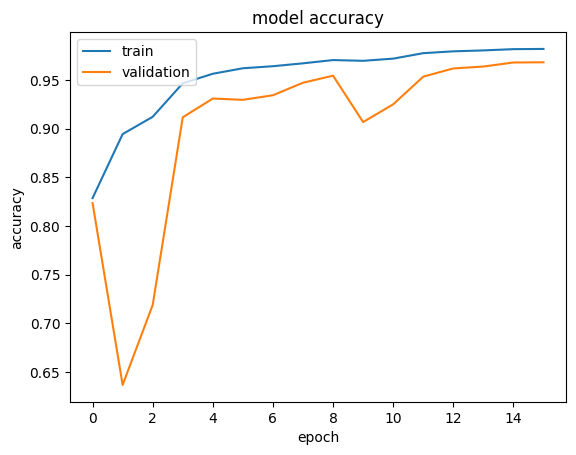

In [17]:
plot_hist(model_history)

### Evaluate the model

In [15]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

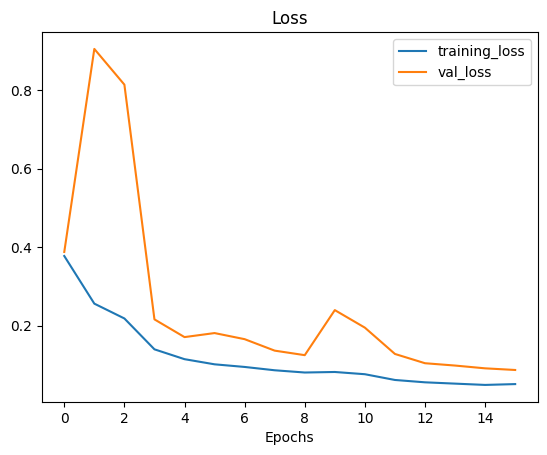

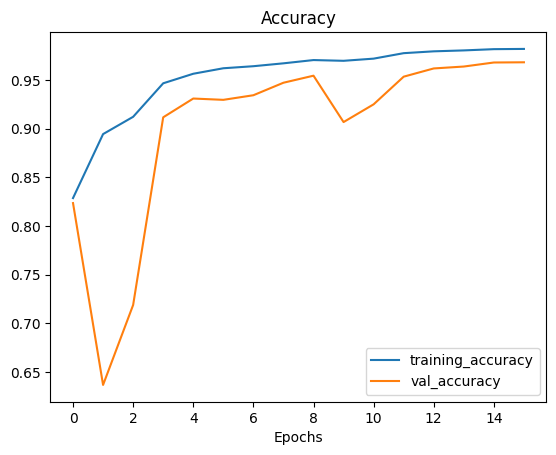

In [19]:
plot_loss_curves(model_history)

In [16]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# func to generate different score and confusion matrix from test score.
def gen_test_data(model):
    # Generate Confusion Matrix
    y_pred = model.predict(test_data)
    y_test = test_data.classes
    
#     y_pred_labels = np.argmax(y_pred, axis=1)
    y_pred_labels = (y_pred > 0.5).astype(np.float32)

    confusion_mat = confusion_matrix(y_test, y_pred_labels)
    print(confusion_mat)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels = [False, True])

    cm_display.plot(cmap="Blues")
    plt.show()
    
    # Get AUC, ROC and Precision Score
    print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
    print("AP Score:", metrics.average_precision_score(y_test, y_pred))
    print()
    print(metrics.classification_report(y_test, y_pred_labels))
    accu = np.sum(np.equal(y_test, y_pred_labels.reshape(-1))) / len(y_test)
    print('Final Test Acccuracy = {:.3f}'.format(accu*100))

55095/55095 [==============================] - 609s 11ms/step
[[24274  1408]
 [ 1278 28135]]


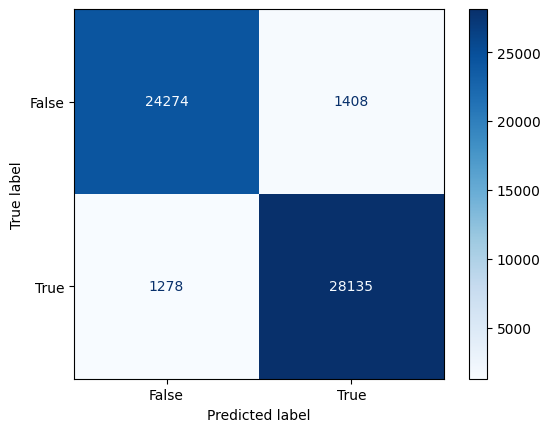

ROC AUC Score: 0.9903713249323491
AP Score: 0.991501427840924

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     25682
           1       0.95      0.96      0.95     29413

    accuracy                           0.95     55095
   macro avg       0.95      0.95      0.95     55095
weighted avg       0.95      0.95      0.95     55095

Final Test Acccuracy = 95.125


In [23]:
gen_test_data(model)

In [ ]:
best_model = load_model(checkpoint_path)

In [ ]:
gen_test_data(best_model)

In [22]:
model.save(model_dir + model_name + "V2_last.keras")
best_model.save(model_dir + model_name + "V2_best.keras")

### Inference

In [16]:
model = load_model(model_dir + model_name + "V2_last.keras")

55095/55095 [==============================] - 577s 10ms/step
[[24274  1408]
 [ 1278 28135]]


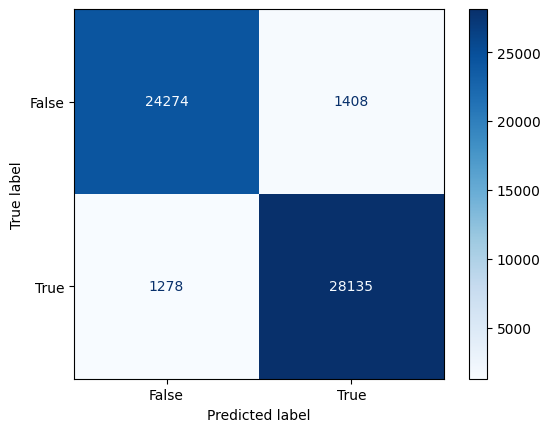

ROC AUC Score: 0.9903694934151603
AP Score: 0.9915001058845269

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     25682
           1       0.95      0.96      0.95     29413

    accuracy                           0.95     55095
   macro avg       0.95      0.95      0.95     55095
weighted avg       0.95      0.95      0.95     55095

Final Test Acccuracy = 95.125


In [18]:
gen_test_data(model)

### Predict custom images

In [17]:
def load_image(img_path, show=True):

    img = load_img(img_path, target_size=(224,224))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

In [18]:
def pred_img(image_tensor, model):
    pred = model.predict(image_tensor)
    prob = pred.reshape(-1)[0]
    label = 'Real' if prob > 0.5 else 'Fake'
    print(f"\nReal: {prob:.10f}")
    print(f"Fake: {1-prob:.10f}")
    print(f"\nFinal Prediction: {label}")